In [83]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.tree import DecisionTreeClassifier, _tree, plot_tree
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries imported")

✓ Libraries imported


In [84]:
feature_names = pd.read_csv('../column_order_401_9_jan.csv')['features'].tolist()

with open('../model_401_9_jan.pkl', 'rb') as f:
    model = pickle.load(f)

# Assign feature names to the booster
booster = model.get_booster()
booster.feature_names = feature_names
model.gpu_id = None
model.predictor = None
model.use_label_encoder = None

# np.array(feature_names)[np.argsort(model.feature_importances_)[::-1]]

[16:42:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [85]:
# Load and prepare data
df = pd.read_parquet('../actual_data.parquet')
print(f"✓ Data loaded: {df.shape}")

# Clean data
df = df.replace([np.inf, -np.inf], np.nan)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')
df = df.fillna(-99999)

# Date splits
june_2024_end = pd.Timestamp('2024-06-30')
july_2024_end = pd.Timestamp('2024-07-31')
august_2024_end = pd.Timestamp('2024-08-31')

train_df = df[pd.to_datetime(df['CUTOFF_DATE']) <= june_2024_end].query("EVER_4DPD_IN_120DAYS != -99999").copy()
test_df = df[(pd.to_datetime(df['CUTOFF_DATE']) > july_2024_end) & 
              (pd.to_datetime(df['CUTOFF_DATE']) <= august_2024_end)].copy()
val_df = df[(pd.to_datetime(df['CUTOFF_DATE']) > june_2024_end) & 
              (pd.to_datetime(df['CUTOFF_DATE']) <= july_2024_end)].copy()

# Extract X and y
X_train = train_df[feature_names].clip(lower=-1e20, upper=1e20).copy()
y_train = train_df['EVER_4DPD_IN_120DAYS'].copy()
X_test = test_df[feature_names].copy()
y_test = test_df['EVER_4DPD_IN_120DAYS'].copy()
X_val = val_df[feature_names].copy()
y_val = val_df['EVER_4DPD_IN_120DAYS'].copy()


✓ Data loaded: (135592, 363)


In [86]:
# Check fresh vs renewal distribution
print("Fresh vs Renewal Distribution:")
print(df['IS_RENEWAL_CUSTOMER'].value_counts())
print("\n")

# Separate data by Fresh vs Renewal
fresh_df = df[df['IS_RENEWAL_CUSTOMER'] == 0].copy()
renewal_df = df[df['IS_RENEWAL_CUSTOMER'] == 1].copy()

print(f"Fresh Customers: {len(fresh_df):,} ({len(fresh_df)/len(df)*100:.1f}%)")
print(f"Renewal Customers: {len(renewal_df):,} ({len(renewal_df)/len(df)*100:.1f}%)")

# Split Fresh data into train, test, val
fresh_train_df = fresh_df[pd.to_datetime(fresh_df['CUTOFF_DATE']) <= june_2024_end].query("EVER_4DPD_IN_120DAYS != -99999").copy()
fresh_test_df = fresh_df[(pd.to_datetime(fresh_df['CUTOFF_DATE']) > july_2024_end) & 
                          (pd.to_datetime(fresh_df['CUTOFF_DATE']) <= august_2024_end)].copy()
fresh_val_df = fresh_df[(pd.to_datetime(fresh_df['CUTOFF_DATE']) > june_2024_end) & 
                        (pd.to_datetime(fresh_df['CUTOFF_DATE']) <= july_2024_end)].copy()

# Split Renewal data into train, test, val
renewal_train_df = renewal_df[pd.to_datetime(renewal_df['CUTOFF_DATE']) <= june_2024_end].query("EVER_4DPD_IN_120DAYS != -99999").copy()
renewal_test_df = renewal_df[(pd.to_datetime(renewal_df['CUTOFF_DATE']) > july_2024_end) & 
                              (pd.to_datetime(renewal_df['CUTOFF_DATE']) <= august_2024_end)].copy()
renewal_val_df = renewal_df[(pd.to_datetime(renewal_df['CUTOFF_DATE']) > june_2024_end) & 
                            (pd.to_datetime(renewal_df['CUTOFF_DATE']) <= july_2024_end)].copy()

# Extract X and y for Fresh
X_fresh_train = fresh_train_df[feature_names].clip(lower=-1e20, upper=1e20).copy()
y_fresh_train = fresh_train_df['EVER_4DPD_IN_120DAYS'].copy()
X_fresh_test = fresh_test_df[feature_names].copy()
y_fresh_test = fresh_test_df['EVER_4DPD_IN_120DAYS'].copy()

# Extract X and y for Renewal
X_renewal_train = renewal_train_df[feature_names].clip(lower=-1e20, upper=1e20).copy()
y_renewal_train = renewal_train_df['EVER_4DPD_IN_120DAYS'].copy()
X_renewal_test = renewal_test_df[feature_names].copy()
y_renewal_test = renewal_test_df['EVER_4DPD_IN_120DAYS'].copy()

print(f"\nFresh Train: {len(X_fresh_train):,} samples")
print(f"Fresh Test: {len(X_fresh_test):,} samples")
print(f"Renewal Train: {len(X_renewal_train):,} samples")
print(f"Renewal Test: {len(X_renewal_test):,} samples")

Fresh vs Renewal Distribution:
IS_RENEWAL_CUSTOMER
0    96211
1    39381
Name: count, dtype: int64


Fresh Customers: 96,211 (71.0%)
Renewal Customers: 39,381 (29.0%)

Fresh Train: 88,095 samples
Fresh Test: 2,932 samples
Renewal Train: 35,113 samples
Renewal Test: 1,648 samples


## Performance Analysis - Fresh vs Renewal Customers


In [87]:
# Generate predictions for Fresh customers
print("Generating predictions for Fresh customers...")
y_fresh_train_pred_proba = model.predict_proba(X_fresh_train)[:, 1]
y_fresh_test_pred_proba = model.predict_proba(X_fresh_test)[:, 1]

y_fresh_train_pred = (y_fresh_train_pred_proba >= 0.5).astype(int)
y_fresh_test_pred = (y_fresh_test_pred_proba >= 0.5).astype(int)

# Generate predictions for Renewal customers
print("Generating predictions for Renewal customers...")
y_renewal_train_pred_proba = model.predict_proba(X_renewal_train)[:, 1]
y_renewal_test_pred_proba = model.predict_proba(X_renewal_test)[:, 1]

y_renewal_train_pred = (y_renewal_train_pred_proba >= 0.5).astype(int)
y_renewal_test_pred = (y_renewal_test_pred_proba >= 0.5).astype(int)

print("✓ Predictions generated for both Fresh and Renewal customers")


Generating predictions for Fresh customers...
Generating predictions for Renewal customers...
✓ Predictions generated for both Fresh and Renewal customers


In [88]:
# Calculate performance metrics for Fresh vs Renewal
print("\n" + "=" * 120)
print("OVERALL PERFORMANCE METRICS - FRESH VS RENEWAL")
print("=" * 120)

# Fresh metrics
fresh_train_metrics = {
    'Accuracy': accuracy_score(y_fresh_train, y_fresh_train_pred),
    'Precision': precision_score(y_fresh_train, y_fresh_train_pred, zero_division=0),
    'Recall': recall_score(y_fresh_train, y_fresh_train_pred, zero_division=0),
    'F1': f1_score(y_fresh_train, y_fresh_train_pred, zero_division=0),
    'AUC-ROC': roc_auc_score(y_fresh_train, y_fresh_train_pred_proba)
}

fresh_test_metrics = {
    'Accuracy': accuracy_score(y_fresh_test, y_fresh_test_pred),
    'Precision': precision_score(y_fresh_test, y_fresh_test_pred, zero_division=0),
    'Recall': recall_score(y_fresh_test, y_fresh_test_pred, zero_division=0),
    'F1': f1_score(y_fresh_test, y_fresh_test_pred, zero_division=0),
    'AUC-ROC': roc_auc_score(y_fresh_test, y_fresh_test_pred_proba)
}

# Renewal metrics
renewal_train_metrics = {
    'Accuracy': accuracy_score(y_renewal_train, y_renewal_train_pred),
    'Precision': precision_score(y_renewal_train, y_renewal_train_pred, zero_division=0),
    'Recall': recall_score(y_renewal_train, y_renewal_train_pred, zero_division=0),
    'F1': f1_score(y_renewal_train, y_renewal_train_pred, zero_division=0),
    'AUC-ROC': roc_auc_score(y_renewal_train, y_renewal_train_pred_proba)
}

renewal_test_metrics = {
    'Accuracy': accuracy_score(y_renewal_test, y_renewal_test_pred),
    'Precision': precision_score(y_renewal_test, y_renewal_test_pred, zero_division=0),
    'Recall': recall_score(y_renewal_test, y_renewal_test_pred, zero_division=0),
    'F1': f1_score(y_renewal_test, y_renewal_test_pred, zero_division=0),
    'AUC-ROC': roc_auc_score(y_renewal_test, y_renewal_test_pred_proba)
}

print("\n" + "=" * 120)
print("FRESH CUSTOMERS")
print("=" * 120)
print("\nTRAIN SET:")
for metric, value in fresh_train_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

print("\nTEST SET:")
for metric, value in fresh_test_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

print("\n" + "=" * 120)
print("RENEWAL CUSTOMERS")
print("=" * 120)
print("\nTRAIN SET:")
for metric, value in renewal_train_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

print("\nTEST SET:")
for metric, value in renewal_test_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

print("\n" + "=" * 120)



OVERALL PERFORMANCE METRICS - FRESH VS RENEWAL

FRESH CUSTOMERS

TRAIN SET:
  Accuracy    : 0.7317
  Precision   : 0.6992
  Recall      : 0.2752
  F1          : 0.3949
  AUC-ROC     : 0.7654

TEST SET:
  Accuracy    : 0.7271
  Precision   : 0.5219
  Recall      : 0.1907
  F1          : 0.2793
  AUC-ROC     : 0.6497

RENEWAL CUSTOMERS

TRAIN SET:
  Accuracy    : 0.8198
  Precision   : 0.7897
  Recall      : 0.5330
  F1          : 0.6364
  AUC-ROC     : 0.8748

TEST SET:
  Accuracy    : 0.8083
  Precision   : 0.5833
  Recall      : 0.5428
  F1          : 0.5623
  AUC-ROC     : 0.8164



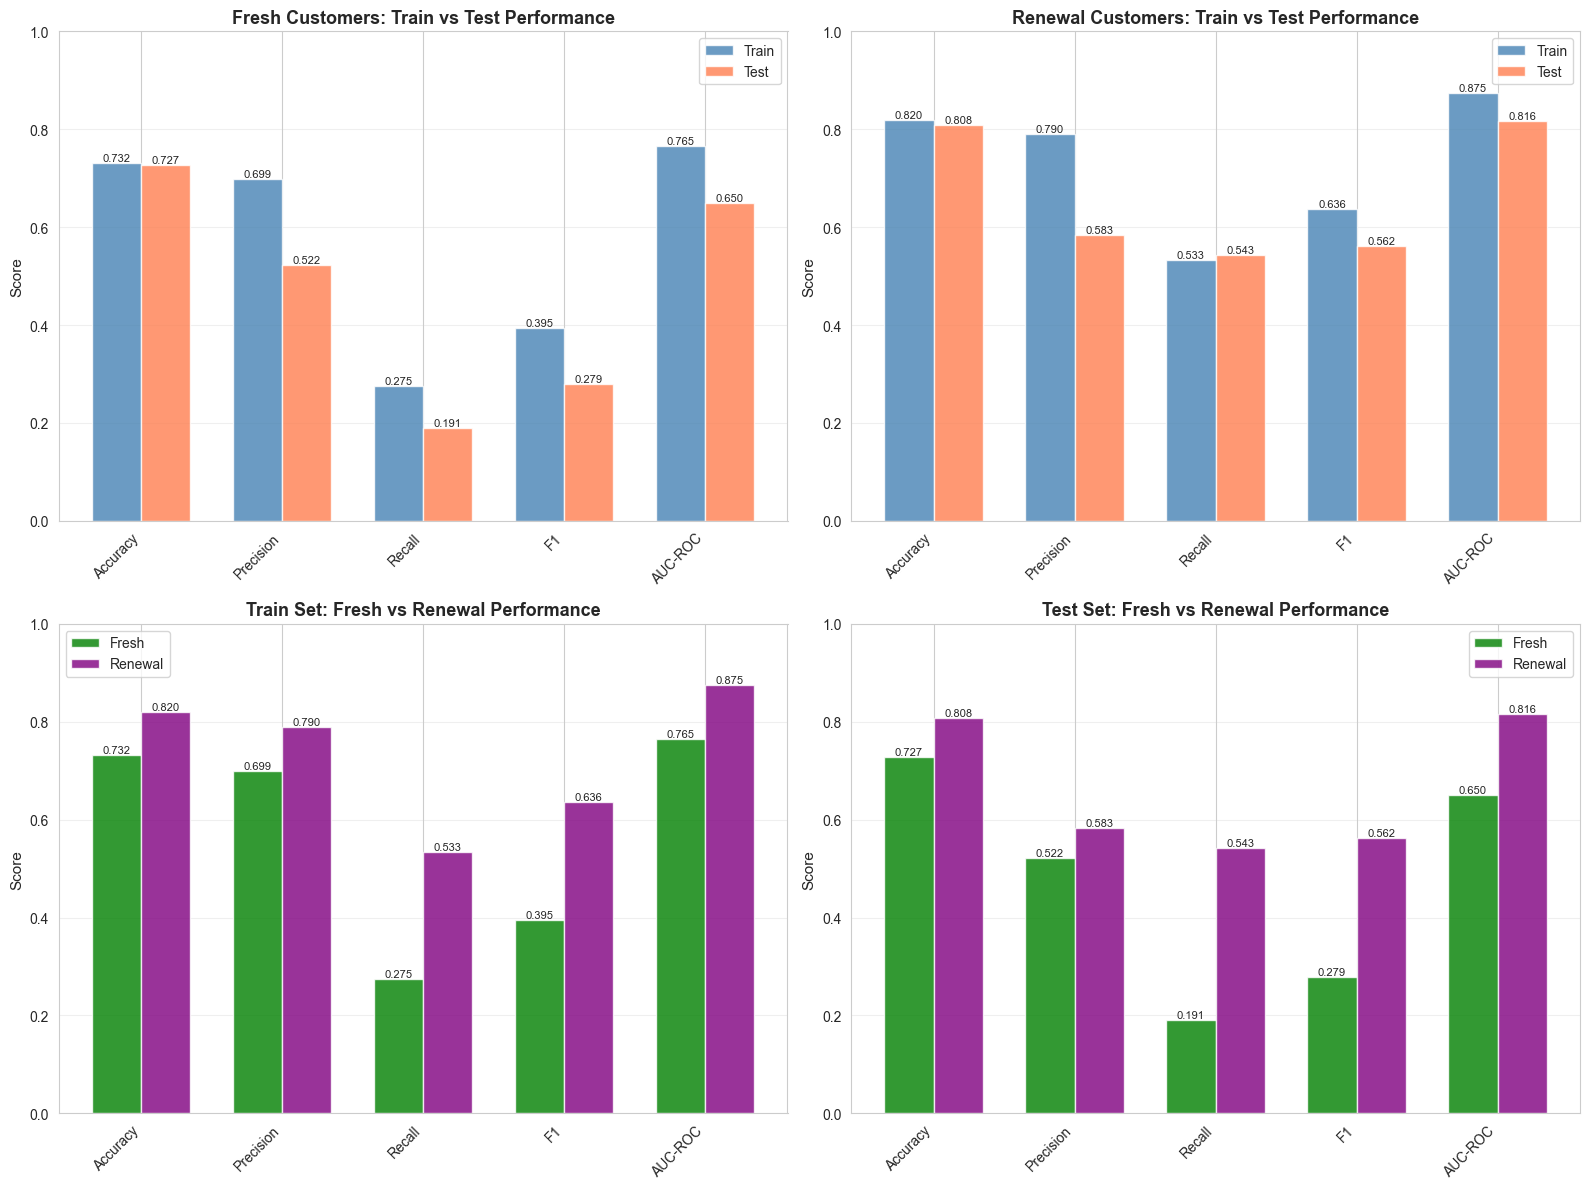

In [89]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for plotting
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']
fresh_train_values = [fresh_train_metrics[m] for m in metrics_names]
fresh_test_values = [fresh_test_metrics[m] for m in metrics_names]
renewal_train_values = [renewal_train_metrics[m] for m in metrics_names]
renewal_test_values = [renewal_test_metrics[m] for m in metrics_names]

# Plot 1: Fresh Train vs Test
ax1 = axes[0, 0]
x = np.arange(len(metrics_names))
width = 0.35
bars1 = ax1.bar(x - width/2, fresh_train_values, width, label='Train', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, fresh_test_values, width, label='Test', alpha=0.8, color='coral')
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Fresh Customers: Train vs Test Performance', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Renewal Train vs Test
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, renewal_train_values, width, label='Train', alpha=0.8, color='steelblue')
bars4 = ax2.bar(x + width/2, renewal_test_values, width, label='Test', alpha=0.8, color='coral')
ax2.set_ylabel('Score', fontsize=11)
ax2.set_title('Renewal Customers: Train vs Test Performance', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1])

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 3: Fresh vs Renewal on Train
ax3 = axes[1, 0]
bars5 = ax3.bar(x - width/2, fresh_train_values, width, label='Fresh', alpha=0.8, color='green')
bars6 = ax3.bar(x + width/2, renewal_train_values, width, label='Renewal', alpha=0.8, color='purple')
ax3.set_ylabel('Score', fontsize=11)
ax3.set_title('Train Set: Fresh vs Renewal Performance', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1])

# Add value labels
for bars in [bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 4: Fresh vs Renewal on Test
ax4 = axes[1, 1]
bars7 = ax4.bar(x - width/2, fresh_test_values, width, label='Fresh', alpha=0.8, color='green')
bars8 = ax4.bar(x + width/2, renewal_test_values, width, label='Renewal', alpha=0.8, color='purple')
ax4.set_ylabel('Score', fontsize=11)
ax4.set_title('Test Set: Fresh vs Renewal Performance', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_names, rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1])

# Add value labels
for bars in [bars7, bars8]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### Error Analysis - Fresh Customers


In [ ]:
# Calculate prediction errors for Fresh customers
fresh_train_errors = (y_fresh_train != y_fresh_train_pred).astype(int)
fresh_test_errors = (y_fresh_test != y_fresh_test_pred).astype(int)

# Calculate absolute residuals
fresh_train_residuals = np.abs(y_fresh_train_pred_proba - y_fresh_train)
fresh_test_residuals = np.abs(y_fresh_test_pred_proba - y_fresh_test)

# Create dataframes with features, actuals, predictions, and errors
fresh_train_analysis_df = X_fresh_train.copy()
fresh_train_analysis_df['actual'] = y_fresh_train.values
fresh_train_analysis_df['predicted_proba'] = y_fresh_train_pred_proba
fresh_train_analysis_df['predicted'] = y_fresh_train_pred
fresh_train_analysis_df['error'] = fresh_train_errors
fresh_train_analysis_df['residual'] = fresh_train_residuals
fresh_train_analysis_df['dataset'] = 'train'
fresh_train_analysis_df['segment'] = 'Fresh'

fresh_test_analysis_df = X_fresh_test.copy()
fresh_test_analysis_df['actual'] = y_fresh_test.values
fresh_test_analysis_df['predicted_proba'] = y_fresh_test_pred_proba
fresh_test_analysis_df['predicted'] = y_fresh_test_pred
fresh_test_analysis_df['error'] = fresh_test_errors
fresh_test_analysis_df['residual'] = fresh_test_residuals
fresh_test_analysis_df['dataset'] = 'test'
fresh_test_analysis_df['segment'] = 'Fresh'

print(f"Fresh Train errors: {fresh_train_errors.sum():,} / {len(fresh_train_errors):,} ({fresh_train_errors.mean()*100:.2f}%)")
print(f"Fresh Test errors: {fresh_test_errors.sum():,} / {len(fresh_test_errors):,} ({fresh_test_errors.mean()*100:.2f}%)")
print(f"\nMean Fresh train residual: {fresh_train_residuals.mean():.4f}")
print(f"Mean Fresh test residual: {fresh_test_residuals.mean():.4f}")


Fresh Train errors: 23,636 / 88,095 (26.83%)
Fresh Test errors: 800 / 2,932 (27.29%)

Mean Fresh train residual: 0.3722
Mean Fresh test residual: 0.3934


### Error Analysis - Renewal Customers


In [91]:
# Calculate prediction errors for Renewal customers
renewal_train_errors = (y_renewal_train != y_renewal_train_pred).astype(int)
renewal_test_errors = (y_renewal_test != y_renewal_test_pred).astype(int)

# Calculate absolute residuals
renewal_train_residuals = np.abs(y_renewal_train_pred_proba - y_renewal_train)
renewal_test_residuals = np.abs(y_renewal_test_pred_proba - y_renewal_test)

# Create dataframes with features, actuals, predictions, and errors
renewal_train_analysis_df = X_renewal_train.copy()
renewal_train_analysis_df['actual'] = y_renewal_train.values
renewal_train_analysis_df['predicted_proba'] = y_renewal_train_pred_proba
renewal_train_analysis_df['predicted'] = y_renewal_train_pred
renewal_train_analysis_df['error'] = renewal_train_errors
renewal_train_analysis_df['residual'] = renewal_train_residuals
renewal_train_analysis_df['dataset'] = 'train'
renewal_train_analysis_df['segment'] = 'Renewal'

renewal_test_analysis_df = X_renewal_test.copy()
renewal_test_analysis_df['actual'] = y_renewal_test.values
renewal_test_analysis_df['predicted_proba'] = y_renewal_test_pred_proba
renewal_test_analysis_df['predicted'] = y_renewal_test_pred
renewal_test_analysis_df['error'] = renewal_test_errors
renewal_test_analysis_df['residual'] = renewal_test_residuals
renewal_test_analysis_df['dataset'] = 'test'
renewal_test_analysis_df['segment'] = 'Renewal'

print(f"Renewal Train errors: {renewal_train_errors.sum():,} / {len(renewal_train_errors):,} ({renewal_train_errors.mean()*100:.2f}%)")
print(f"Renewal Test errors: {renewal_test_errors.sum():,} / {len(renewal_test_errors):,} ({renewal_test_errors.mean()*100:.2f}%)")
print(f"\nMean Renewal train residual: {renewal_train_residuals.mean():.4f}")
print(f"Mean Renewal test residual: {renewal_test_residuals.mean():.4f}")


Renewal Train errors: 6,328 / 35,113 (18.02%)
Renewal Test errors: 316 / 1,648 (19.17%)

Mean Renewal train residual: 0.2789
Mean Renewal test residual: 0.2995


### Decision Tree Analysis - Fresh Customers


In [92]:
# Get feature importance from the overall model
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Calculate feature importance
importance_gain = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain': [importance_gain.get(f, 0) for f in feature_names]
})
importance_df = importance_df.sort_values('Gain', ascending=False).reset_index(drop=True)

# Combine Fresh train and test for analysis
fresh_combined_df = pd.concat([fresh_train_analysis_df, fresh_test_analysis_df], ignore_index=True)

# Fit a decision tree to predict high error populations for Fresh customers
high_error_threshold = fresh_combined_df['residual'].quantile(0.75)
fresh_combined_df['high_error'] = (fresh_combined_df['residual'] > high_error_threshold).astype(int)

print("=" * 120)
print("DECISION TREE TO IDENTIFY POOR PERFORMANCE POPULATIONS - FRESH CUSTOMERS")
print("=" * 120)
print(f"\nHigh error threshold (75th percentile): {high_error_threshold:.4f}")
print(f"Samples with high error: {fresh_combined_df['high_error'].sum():,} / {len(fresh_combined_df):,} ({fresh_combined_df['high_error'].mean()*100:.2f}%)")

# Use top features for interpretability
top_30_features = importance_df.head(30)['Feature'].tolist()
X_fresh_combined = fresh_combined_df[top_30_features]
y_fresh_high_error = fresh_combined_df['high_error']

dt_fresh_error = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=500,
    min_samples_split=200,
    random_state=42
)

dt_fresh_error.fit(X_fresh_combined, y_fresh_high_error)
print(f"\n✓ Decision tree fitted for Fresh customers (max_depth={dt_fresh_error.max_depth})")
print(f"Train accuracy: {dt_fresh_error.score(X_fresh_combined, y_fresh_high_error):.4f}")


DECISION TREE TO IDENTIFY POOR PERFORMANCE POPULATIONS - FRESH CUSTOMERS

High error threshold (75th percentile): 0.5173
Samples with high error: 22,757 / 91,027 (25.00%)

✓ Decision tree fitted for Fresh customers (max_depth=5)
Train accuracy: 0.7500


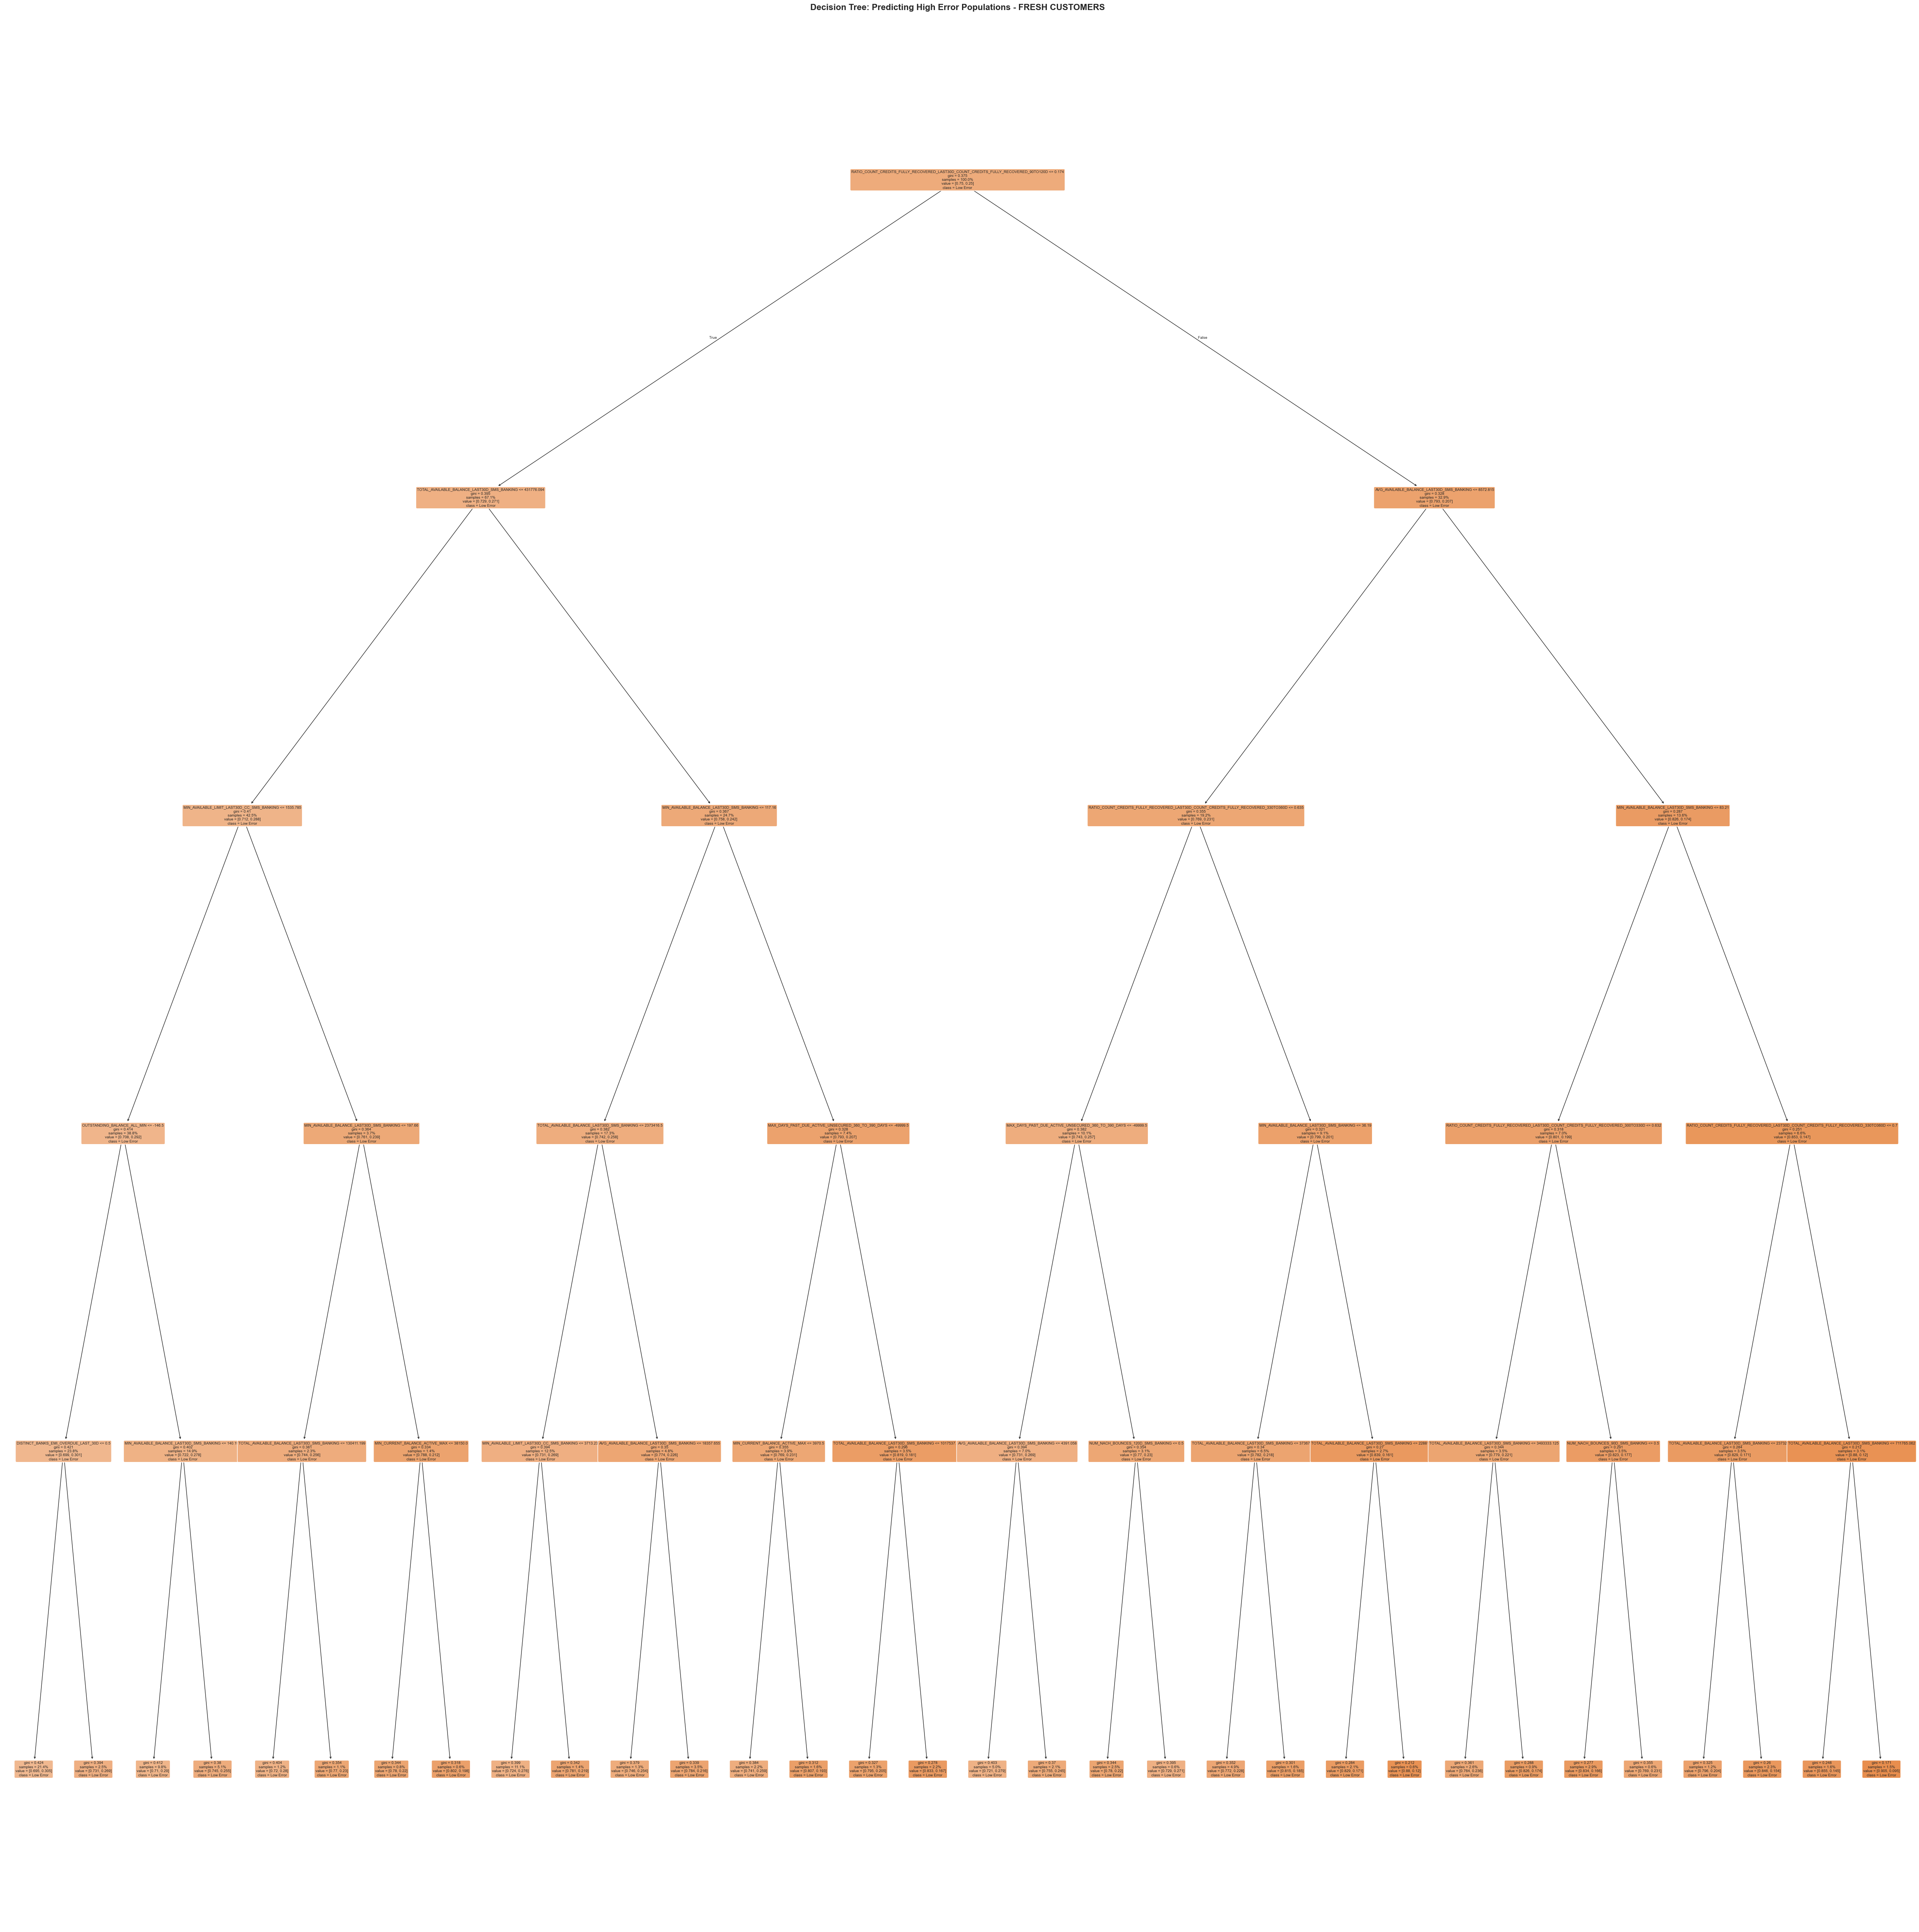


✓ Decision tree visualization for Fresh customers displayed


In [93]:
# Visualize the Fresh error prediction tree
plt.figure(figsize=(50, 50))
plot_tree(
    dt_fresh_error,
    feature_names=top_30_features,
    class_names=['Low Error', 'High Error'],
    filled=True,
    fontsize=7,
    rounded=True,
    proportion=True
)
plt.title("Decision Tree: Predicting High Error Populations - FRESH CUSTOMERS", 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✓ Decision tree visualization for Fresh customers displayed")


### Decision Tree Analysis - Renewal Customers


In [94]:
# Combine Renewal train and test for analysis
renewal_combined_df = pd.concat([renewal_train_analysis_df, renewal_test_analysis_df], ignore_index=True)

# Fit a decision tree to predict high error populations for Renewal customers
high_error_threshold_renewal = renewal_combined_df['residual'].quantile(0.75)
renewal_combined_df['high_error'] = (renewal_combined_df['residual'] > high_error_threshold_renewal).astype(int)

print("=" * 120)
print("DECISION TREE TO IDENTIFY POOR PERFORMANCE POPULATIONS - RENEWAL CUSTOMERS")
print("=" * 120)
print(f"\nHigh error threshold (75th percentile): {high_error_threshold_renewal:.4f}")
print(f"Samples with high error: {renewal_combined_df['high_error'].sum():,} / {len(renewal_combined_df):,} ({renewal_combined_df['high_error'].mean()*100:.2f}%)")

# Use top features for interpretability
X_renewal_combined = renewal_combined_df[top_30_features]
y_renewal_high_error = renewal_combined_df['high_error']

dt_renewal_error = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=500,
    min_samples_split=200,
    random_state=42
)

dt_renewal_error.fit(X_renewal_combined, y_renewal_high_error)
print(f"\n✓ Decision tree fitted for Renewal customers (max_depth={dt_renewal_error.max_depth})")
print(f"Train accuracy: {dt_renewal_error.score(X_renewal_combined, y_renewal_high_error):.4f}")


DECISION TREE TO IDENTIFY POOR PERFORMANCE POPULATIONS - RENEWAL CUSTOMERS

High error threshold (75th percentile): 0.4035
Samples with high error: 9,190 / 36,761 (25.00%)

✓ Decision tree fitted for Renewal customers (max_depth=5)
Train accuracy: 0.7500


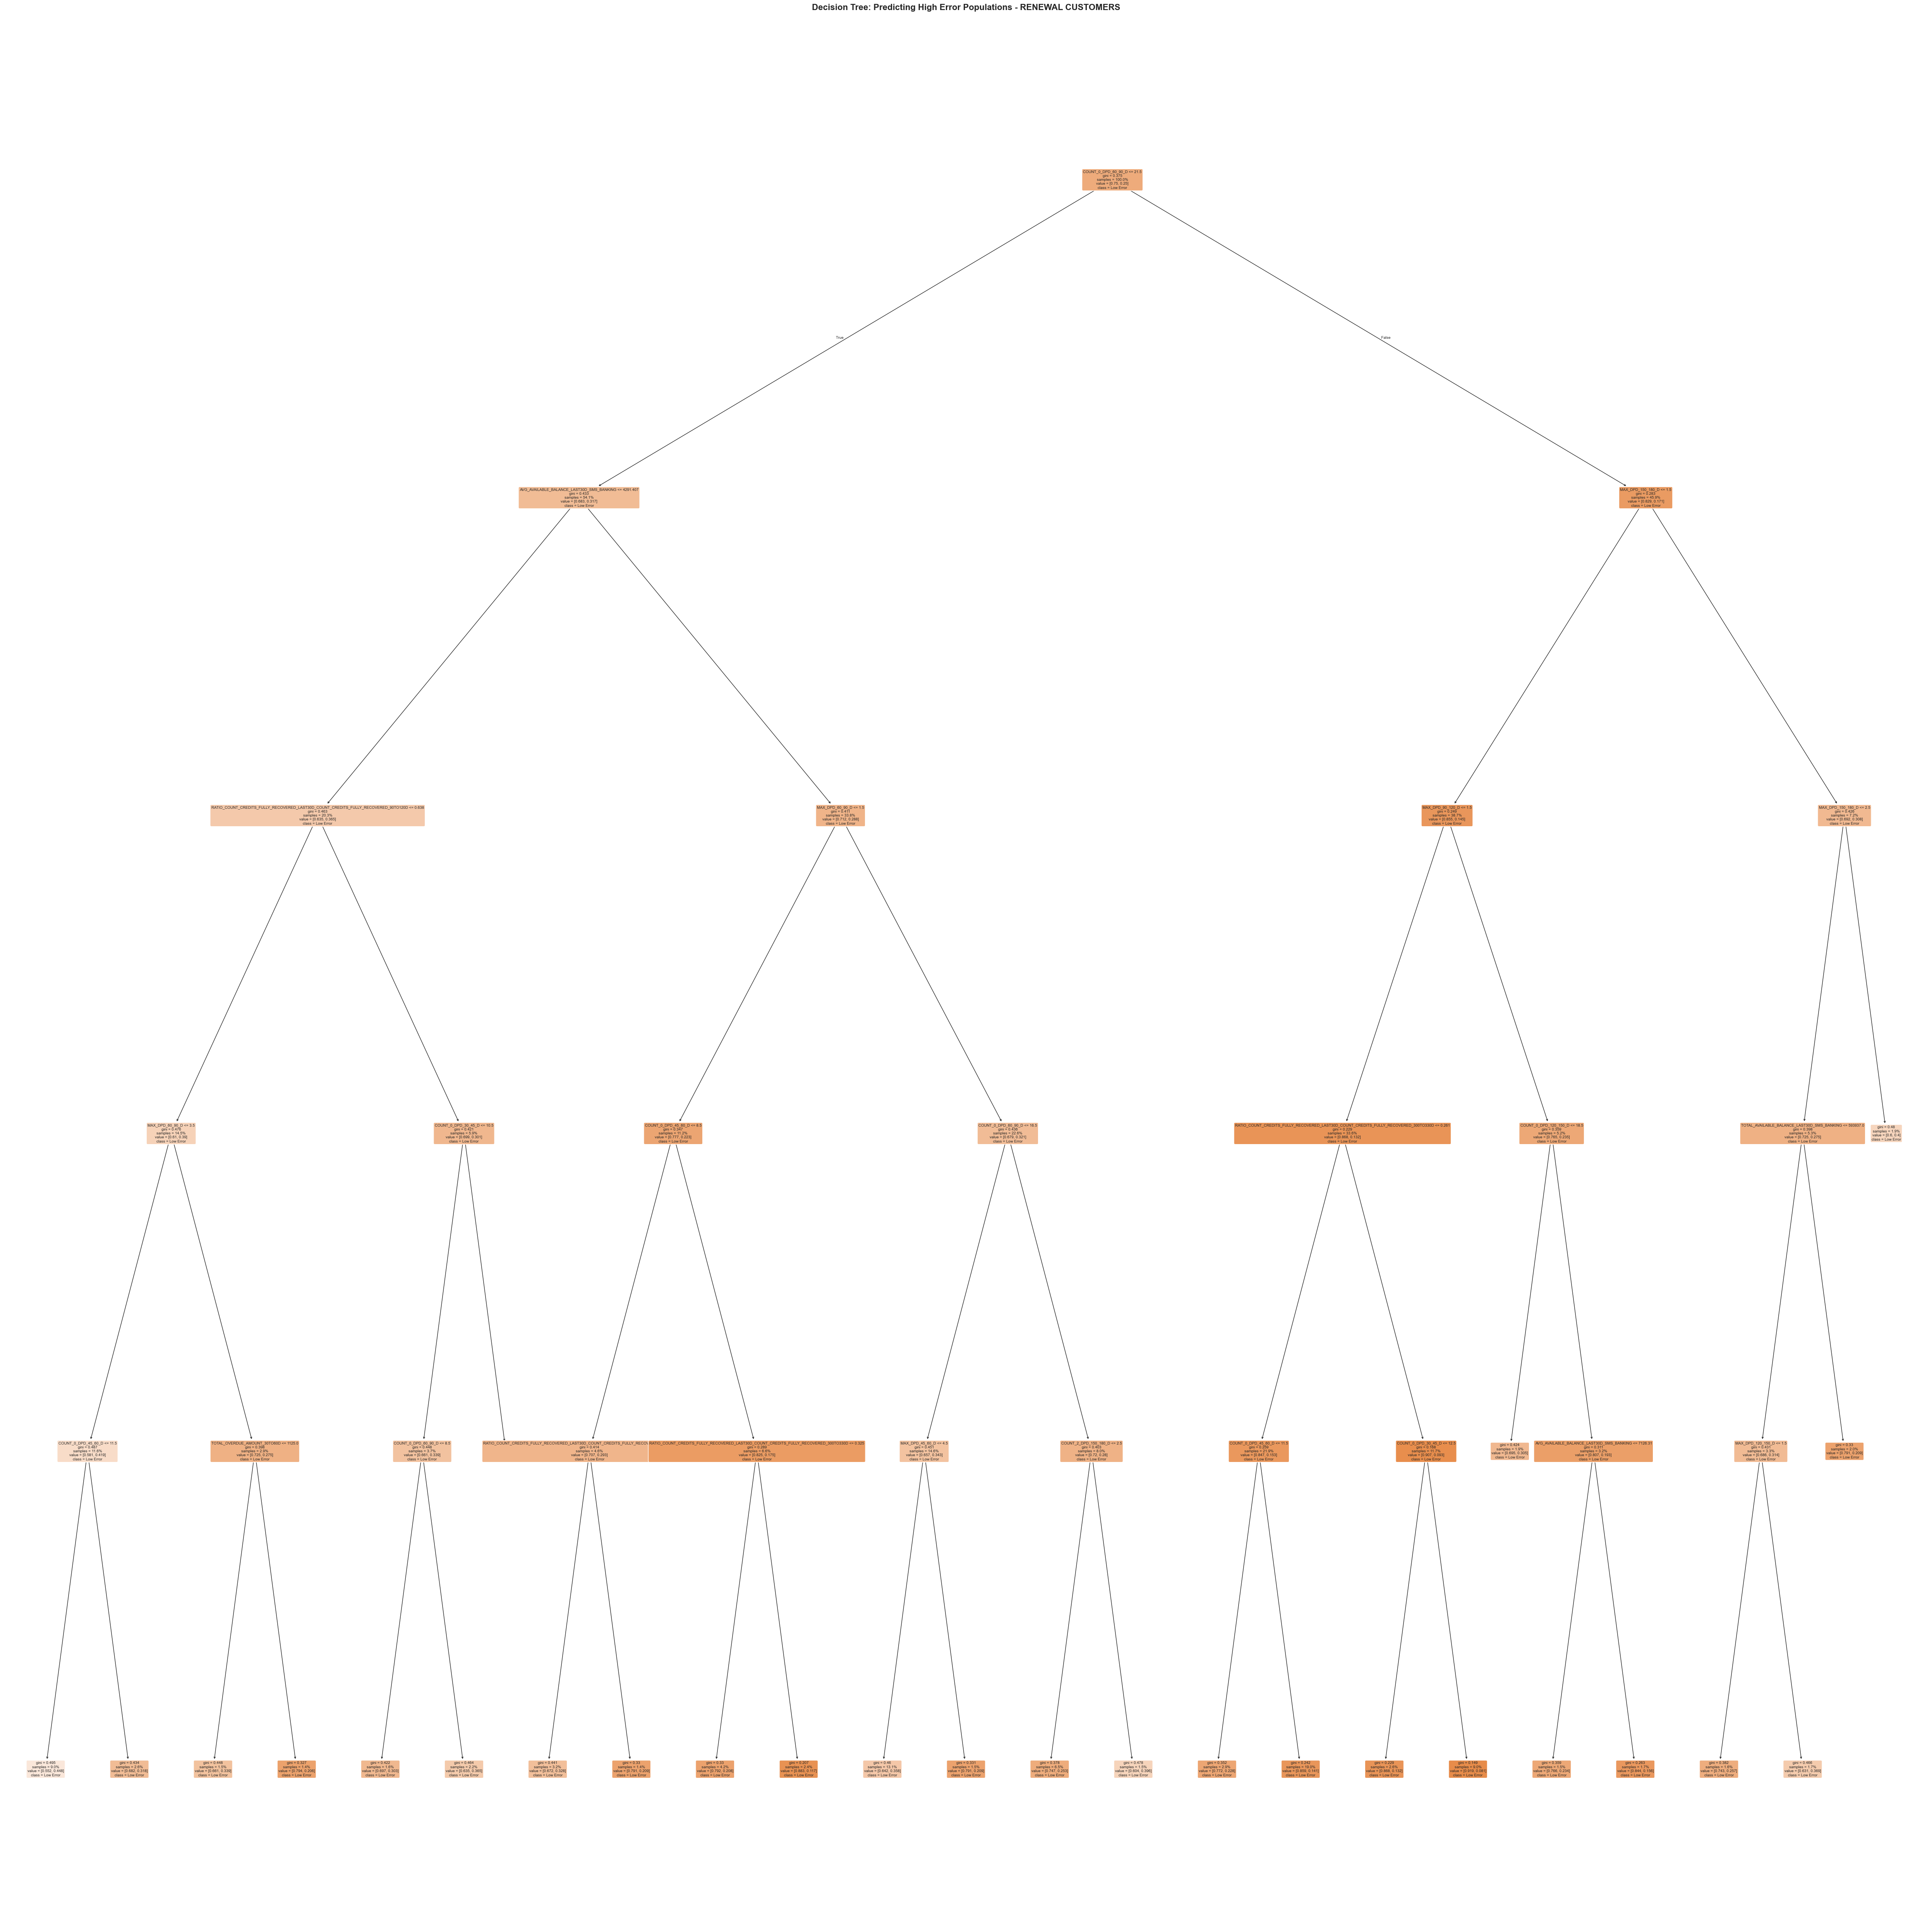


✓ Decision tree visualization for Renewal customers displayed


In [95]:
# Visualize the Renewal error prediction tree
plt.figure(figsize=(50, 50))
plot_tree(
    dt_renewal_error,
    feature_names=top_30_features,
    class_names=['Low Error', 'High Error'],
    filled=True,
    fontsize=7,
    rounded=True,
    proportion=True
)
plt.title("Decision Tree: Predicting High Error Populations - RENEWAL CUSTOMERS", 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✓ Decision tree visualization for Renewal customers displayed")


### Leaf Node Analysis - Fresh Customers


In [96]:
# Extract leaf characteristics from Fresh error prediction tree
def extract_leaf_info_with_empirical_bounds(tree, data_df, node_id=0, depth=0, mask=None, feature_names=None):
    """Recursively extract information about leaf nodes with empirical boundaries"""
    if mask is None:
        mask = np.ones(len(data_df), dtype=bool)
    
    if tree.children_left[node_id] == tree.children_right[node_id]:  # Leaf node
        n_samples = tree.n_node_samples[node_id]
        value = tree.value[node_id][0]
        high_error_rate = value[1] / (value[0] + value[1]) if (value[0] + value[1]) > 0 else 0
        
        return [{
            'node_id': node_id,
            'depth': depth,
            'n_samples': n_samples,
            'n_high_error': int(value[1]),
            'high_error_rate': high_error_rate,
            'mask': mask.copy()
        }]
    else:
        # Internal node
        feature = feature_names[tree.feature[node_id]]
        threshold = tree.threshold[node_id]
        
        # Split the mask
        left_mask = mask & (data_df[feature].values <= threshold)
        right_mask = mask & (data_df[feature].values > threshold)
        
        left_leaves = extract_leaf_info_with_empirical_bounds(
            tree, data_df, tree.children_left[node_id], depth + 1, left_mask, feature_names
        )
        right_leaves = extract_leaf_info_with_empirical_bounds(
            tree, data_df, tree.children_right[node_id], depth + 1, right_mask, feature_names
        )
        
        return left_leaves + right_leaves

def get_empirical_conditions(data_df, mask, feature_names):
    """Get empirical boundaries for features in a leaf"""
    leaf_data = data_df[mask]
    conditions = []
    
    for feature in feature_names:
        min_val = leaf_data[feature].min()
        max_val = leaf_data[feature].max()
        conditions.append(f"{feature}: [{min_val:.4f}, {max_val:.4f}]")
    
    return conditions

fresh_tree_struct = dt_fresh_error.tree_
fresh_leaf_info = extract_leaf_info_with_empirical_bounds(
    fresh_tree_struct, 
    fresh_combined_df[top_30_features], 
    feature_names=top_30_features
)
fresh_leaf_df = pd.DataFrame(fresh_leaf_info)
fresh_leaf_df = fresh_leaf_df.sort_values('high_error_rate', ascending=False)

print("\n" + "=" * 120)
print("TOP 10 LEAF NODES WITH HIGHEST ERROR RATES - FRESH CUSTOMERS")
print("=" * 120)

for idx, row in fresh_leaf_df.head(10).iterrows():
    print(f"\n{'='*120}")
    print(f"LEAF {row['node_id']} (Rank: {fresh_leaf_df.index.get_loc(idx) + 1})")
    print(f"{'='*120}")
    print(f"Samples: {row['n_samples']:,} ({row['n_samples']/len(fresh_combined_df)*100:.2f}% of total)")
    print(f"High Error Count: {row['n_high_error']:,}")
    print(f"High Error Rate: {row['high_error_rate']*100:.2f}%")
    print(f"\nEmpirical Feature Boundaries (min, max):")
    conditions = get_empirical_conditions(fresh_combined_df[top_30_features], row['mask'], top_30_features)
    for i, cond in enumerate(conditions, 1):
        print(f"  {i}. {cond}")



TOP 10 LEAF NODES WITH HIGHEST ERROR RATES - FRESH CUSTOMERS

LEAF 5 (Rank: 1)
Samples: 19,439 (21.36% of total)
High Error Count: 0
High Error Rate: 30.47%

Empirical Feature Boundaries (min, max):
  1. MAX_DPD_60_90_D: [-99999.0000, -99999.0000]
  2. COUNT_0_DPD_45_60_D: [-99999.0000, -99999.0000]
  3. NUM_UNIQUE_LOAN_OVERDUE_30D_SMS_BANKING: [-99999.0000, 2.0000]
  4. COUNT_0_DPD_30_45_D: [-99999.0000, -99999.0000]
  5. COUNT_0_DPD_60_90_D: [-99999.0000, -99999.0000]
  6. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_90TO120D: [-99999.0000, 0.1739]
  7. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_300TO330D: [-99999.0000, 543.0000]
  8. MAX_DPD_90_120_D: [-99999.0000, -99999.0000]
  9. NUM_NACH_BOUNCES_120D_SMS_BANKING: [-99999.0000, 23.0000]
  10. MAX_DPD_150_180_D: [-99999.0000, -99999.0000]
  11. COUNT_3_DPD_60_90_D: [-99999.0000, -99999.0000]
  12. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_

### Leaf Node Analysis - Renewal Customers


In [97]:
# Extract leaf characteristics from Renewal error prediction tree
renewal_tree_struct = dt_renewal_error.tree_
renewal_leaf_info = extract_leaf_info_with_empirical_bounds(
    renewal_tree_struct, 
    renewal_combined_df[top_30_features], 
    feature_names=top_30_features
)
renewal_leaf_df = pd.DataFrame(renewal_leaf_info)
renewal_leaf_df = renewal_leaf_df.sort_values('high_error_rate', ascending=False)

print("\n" + "=" * 120)
print("TOP 10 LEAF NODES WITH HIGHEST ERROR RATES - RENEWAL CUSTOMERS")
print("=" * 120)

for idx, row in renewal_leaf_df.head(10).iterrows():
    print(f"\n{'='*120}")
    print(f"LEAF {row['node_id']} (Rank: {renewal_leaf_df.index.get_loc(idx) + 1})")
    print(f"{'='*120}")
    print(f"Samples: {row['n_samples']:,} ({row['n_samples']/len(renewal_combined_df)*100:.2f}% of total)")
    print(f"High Error Count: {row['n_high_error']:,}")
    print(f"High Error Rate: {row['high_error_rate']*100:.2f}%")
    print(f"\nEmpirical Feature Boundaries (min, max):")
    conditions = get_empirical_conditions(renewal_combined_df[top_30_features], row['mask'], top_30_features)
    for i, cond in enumerate(conditions, 1):
        print(f"  {i}. {cond}")



TOP 10 LEAF NODES WITH HIGHEST ERROR RATES - RENEWAL CUSTOMERS

LEAF 5 (Rank: 1)
Samples: 3,313 (9.01% of total)
High Error Count: 0
High Error Rate: 44.79%

Empirical Feature Boundaries (min, max):
  1. MAX_DPD_60_90_D: [-99999.0000, 3.0000]
  2. COUNT_0_DPD_45_60_D: [-99999.0000, 11.0000]
  3. NUM_UNIQUE_LOAN_OVERDUE_30D_SMS_BANKING: [-99999.0000, 11.0000]
  4. COUNT_0_DPD_30_45_D: [-99999.0000, 15.0000]
  5. COUNT_0_DPD_60_90_D: [-99999.0000, 21.0000]
  6. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_90TO120D: [-99999.0000, 0.6369]
  7. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_300TO330D: [-99999.0000, 80.5000]
  8. MAX_DPD_90_120_D: [-99999.0000, 11.0000]
  9. NUM_NACH_BOUNCES_120D_SMS_BANKING: [-99999.0000, 11.0000]
  10. MAX_DPD_150_180_D: [-99999.0000, 33.0000]
  11. COUNT_3_DPD_60_90_D: [-99999.0000, 8.0000]
  12. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_330TO360D: [-99999.0000, 68.00

### Detailed Population Analysis - Fresh Customers


In [99]:
# Get leaf assignments for Fresh customers
fresh_leaf_assignments = dt_fresh_error.apply(X_fresh_combined)
fresh_combined_df['leaf_id'] = fresh_leaf_assignments

# Analyze top 5 worst performing leaves for Fresh
print("\n" + "=" * 120)
print("DETAILED ANALYSIS: POOR PERFORMANCE POPULATIONS ON TRAIN VS TEST - FRESH CUSTOMERS")
print("=" * 120)

for idx, row in fresh_leaf_df.head(5).iterrows():
    leaf_id = row['node_id']
    
    # Filter samples in this leaf
    leaf_mask = fresh_combined_df['leaf_id'] == leaf_id
    leaf_samples = fresh_combined_df[leaf_mask]
    
    # Separate by train/test
    train_leaf = leaf_samples[leaf_samples['dataset'] == 'train']
    test_leaf = leaf_samples[leaf_samples['dataset'] == 'test']
    
    print(f"\n{'='*120}")
    print(f"LEAF {leaf_id} - Population Characteristics (FRESH)")
    print(f"{'='*120}")
    
    # Overall stats
    print(f"\nTotal Samples: {len(leaf_samples):,}")
    print(f"  Train: {len(train_leaf):,} ({len(train_leaf)/len(leaf_samples)*100:.1f}%)")
    print(f"  Test: {len(test_leaf):,} ({len(test_leaf)/len(leaf_samples)*100:.1f}%)")
    
    # Performance metrics
    print(f"\nPerformance Metrics:")
    print(f"  {'Dataset':<10} {'Error Rate':<15} {'Mean Residual':<20} {'Actual Class 1%':<20} {'Pred Class 1%'}")
    print(f"  {'-'*10} {'-'*15} {'-'*20} {'-'*20} {'-'*15}")
    
    if len(train_leaf) > 0:
        train_error_rate = train_leaf['error'].mean()
        train_mean_residual = train_leaf['residual'].mean()
        train_actual_class1 = train_leaf['actual'].mean()
        train_pred_class1 = train_leaf['predicted'].mean()
        print(f"  {'Train':<10} {train_error_rate*100:>6.2f}%        {train_mean_residual:>8.4f}           {train_actual_class1*100:>7.2f}%            {train_pred_class1*100:>6.2f}%")
    
    if len(test_leaf) > 0:
        test_error_rate = test_leaf['error'].mean()
        test_mean_residual = test_leaf['residual'].mean()
        test_actual_class1 = test_leaf['actual'].mean()
        test_pred_class1 = test_leaf['predicted'].mean()
        print(f"  {'Test':<10} {test_error_rate*100:>6.2f}%        {test_mean_residual:>8.4f}           {test_actual_class1*100:>7.2f}%            {test_pred_class1*100:>6.2f}%")
    
    # Feature statistics
    print(f"\nKey Feature Statistics (Top 5 Important Features):")
    print(f"  {'Feature':<80} {'Mean':<15} {'Median':<15} {'Std'}")
    print(f"  {'-'*80} {'-'*15} {'-'*15} {'-'*15}")
    
    for feat in importance_df.head(5)['Feature'].tolist():
        if feat in leaf_samples.columns:
            feat_mean = leaf_samples[feat].mean()
            feat_median = leaf_samples[feat].median()
            feat_std = leaf_samples[feat].std()
            print(f"  {feat:<80} {feat_mean:>12.4f}    {feat_median:>12.4f}    {feat_std:>12.4f}")
    
    # Show empirical boundaries
    print(f"\nPopulation Definition (Empirical Feature Boundaries):")
    conditions = get_empirical_conditions(fresh_combined_df[top_30_features], row['mask'], top_30_features)
    for i, cond in enumerate(conditions, 1):
        print(f"  {i}. {cond}")



DETAILED ANALYSIS: POOR PERFORMANCE POPULATIONS ON TRAIN VS TEST - FRESH CUSTOMERS

LEAF 5 - Population Characteristics (FRESH)

Total Samples: 19,439
  Train: 18,821 (96.8%)
  Test: 618 (3.2%)

Performance Metrics:
  Dataset    Error Rate      Mean Residual        Actual Class 1%      Pred Class 1%
  ---------- --------------- -------------------- -------------------- ---------------
  Train       34.48%          0.4437             41.29%             21.68%
  Test        32.85%          0.4476             34.63%             17.64%

Key Feature Statistics (Top 5 Important Features):
  Feature                                                                          Mean            Median          Std
  -------------------------------------------------------------------------------- --------------- --------------- ---------------
  MAX_DPD_60_90_D                                                                   -99999.0000     -99999.0000          0.0000
  COUNT_0_DPD_45_60_D          

### Detailed Population Analysis - Renewal Customers


In [100]:
# Get leaf assignments for Renewal customers
renewal_leaf_assignments = dt_renewal_error.apply(X_renewal_combined)
renewal_combined_df['leaf_id'] = renewal_leaf_assignments

# Analyze top 5 worst performing leaves for Renewal
print("\n" + "=" * 120)
print("DETAILED ANALYSIS: POOR PERFORMANCE POPULATIONS ON TRAIN VS TEST - RENEWAL CUSTOMERS")
print("=" * 120)

for idx, row in renewal_leaf_df.head(5).iterrows():
    leaf_id = row['node_id']
    
    # Filter samples in this leaf
    leaf_mask = renewal_combined_df['leaf_id'] == leaf_id
    leaf_samples = renewal_combined_df[leaf_mask]
    
    # Separate by train/test
    train_leaf = leaf_samples[leaf_samples['dataset'] == 'train']
    test_leaf = leaf_samples[leaf_samples['dataset'] == 'test']
    
    print(f"\n{'='*120}")
    print(f"LEAF {leaf_id} - Population Characteristics (RENEWAL)")
    print(f"{'='*120}")
    
    # Overall stats
    print(f"\nTotal Samples: {len(leaf_samples):,}")
    print(f"  Train: {len(train_leaf):,} ({len(train_leaf)/len(leaf_samples)*100:.1f}%)")
    print(f"  Test: {len(test_leaf):,} ({len(test_leaf)/len(leaf_samples)*100:.1f}%)")
    
    # Performance metrics
    print(f"\nPerformance Metrics:")
    print(f"  {'Dataset':<10} {'Error Rate':<15} {'Mean Residual':<20} {'Actual Class 1%':<20} {'Pred Class 1%'}")
    print(f"  {'-'*10} {'-'*15} {'-'*20} {'-'*20} {'-'*15}")
    
    if len(train_leaf) > 0:
        train_error_rate = train_leaf['error'].mean()
        train_mean_residual = train_leaf['residual'].mean()
        train_actual_class1 = train_leaf['actual'].mean()
        train_pred_class1 = train_leaf['predicted'].mean()
        print(f"  {'Train':<10} {train_error_rate*100:>6.2f}%        {train_mean_residual:>8.4f}           {train_actual_class1*100:>7.2f}%            {train_pred_class1*100:>6.2f}%")
    
    if len(test_leaf) > 0:
        test_error_rate = test_leaf['error'].mean()
        test_mean_residual = test_leaf['residual'].mean()
        test_actual_class1 = test_leaf['actual'].mean()
        test_pred_class1 = test_leaf['predicted'].mean()
        print(f"  {'Test':<10} {test_error_rate*100:>6.2f}%        {test_mean_residual:>8.4f}           {test_actual_class1*100:>7.2f}%            {test_pred_class1*100:>6.2f}%")
    
    # Feature statistics
    print(f"\nKey Feature Statistics (Top 5 Important Features):")
    print(f"  {'Feature':<80} {'Mean':<15} {'Median':<15} {'Std'}")
    print(f"  {'-'*80} {'-'*15} {'-'*15} {'-'*15}")
    
    for feat in importance_df.head(5)['Feature'].tolist():
        if feat in leaf_samples.columns:
            feat_mean = leaf_samples[feat].mean()
            feat_median = leaf_samples[feat].median()
            feat_std = leaf_samples[feat].std()
            print(f"  {feat:<80} {feat_mean:>12.4f}    {feat_median:>12.4f}    {feat_std:>12.4f}")
    
    # Show empirical boundaries
    print(f"\nPopulation Definition (Empirical Feature Boundaries):")
    conditions = get_empirical_conditions(renewal_combined_df[top_30_features], row['mask'], top_30_features)
    for i, cond in enumerate(conditions, 1):
        print(f"  {i}. {cond}")



DETAILED ANALYSIS: POOR PERFORMANCE POPULATIONS ON TRAIN VS TEST - RENEWAL CUSTOMERS

LEAF 5 - Population Characteristics (RENEWAL)

Total Samples: 3,313
  Train: 3,191 (96.3%)
  Test: 122 (3.7%)

Performance Metrics:
  Dataset    Error Rate      Mean Residual        Actual Class 1%      Pred Class 1%
  ---------- --------------- -------------------- -------------------- ---------------
  Train       27.14%          0.3878             44.84%             38.20%
  Test        31.15%          0.4117             40.16%             41.80%

Key Feature Statistics (Top 5 Important Features):
  Feature                                                                          Mean            Median          Std
  -------------------------------------------------------------------------------- --------------- --------------- ---------------
  MAX_DPD_60_90_D                                                                   -22243.8503          2.0000      41596.3794
  COUNT_0_DPD_45_60_D        

### Visualization: Error Rates Comparison - Fresh vs Renewal


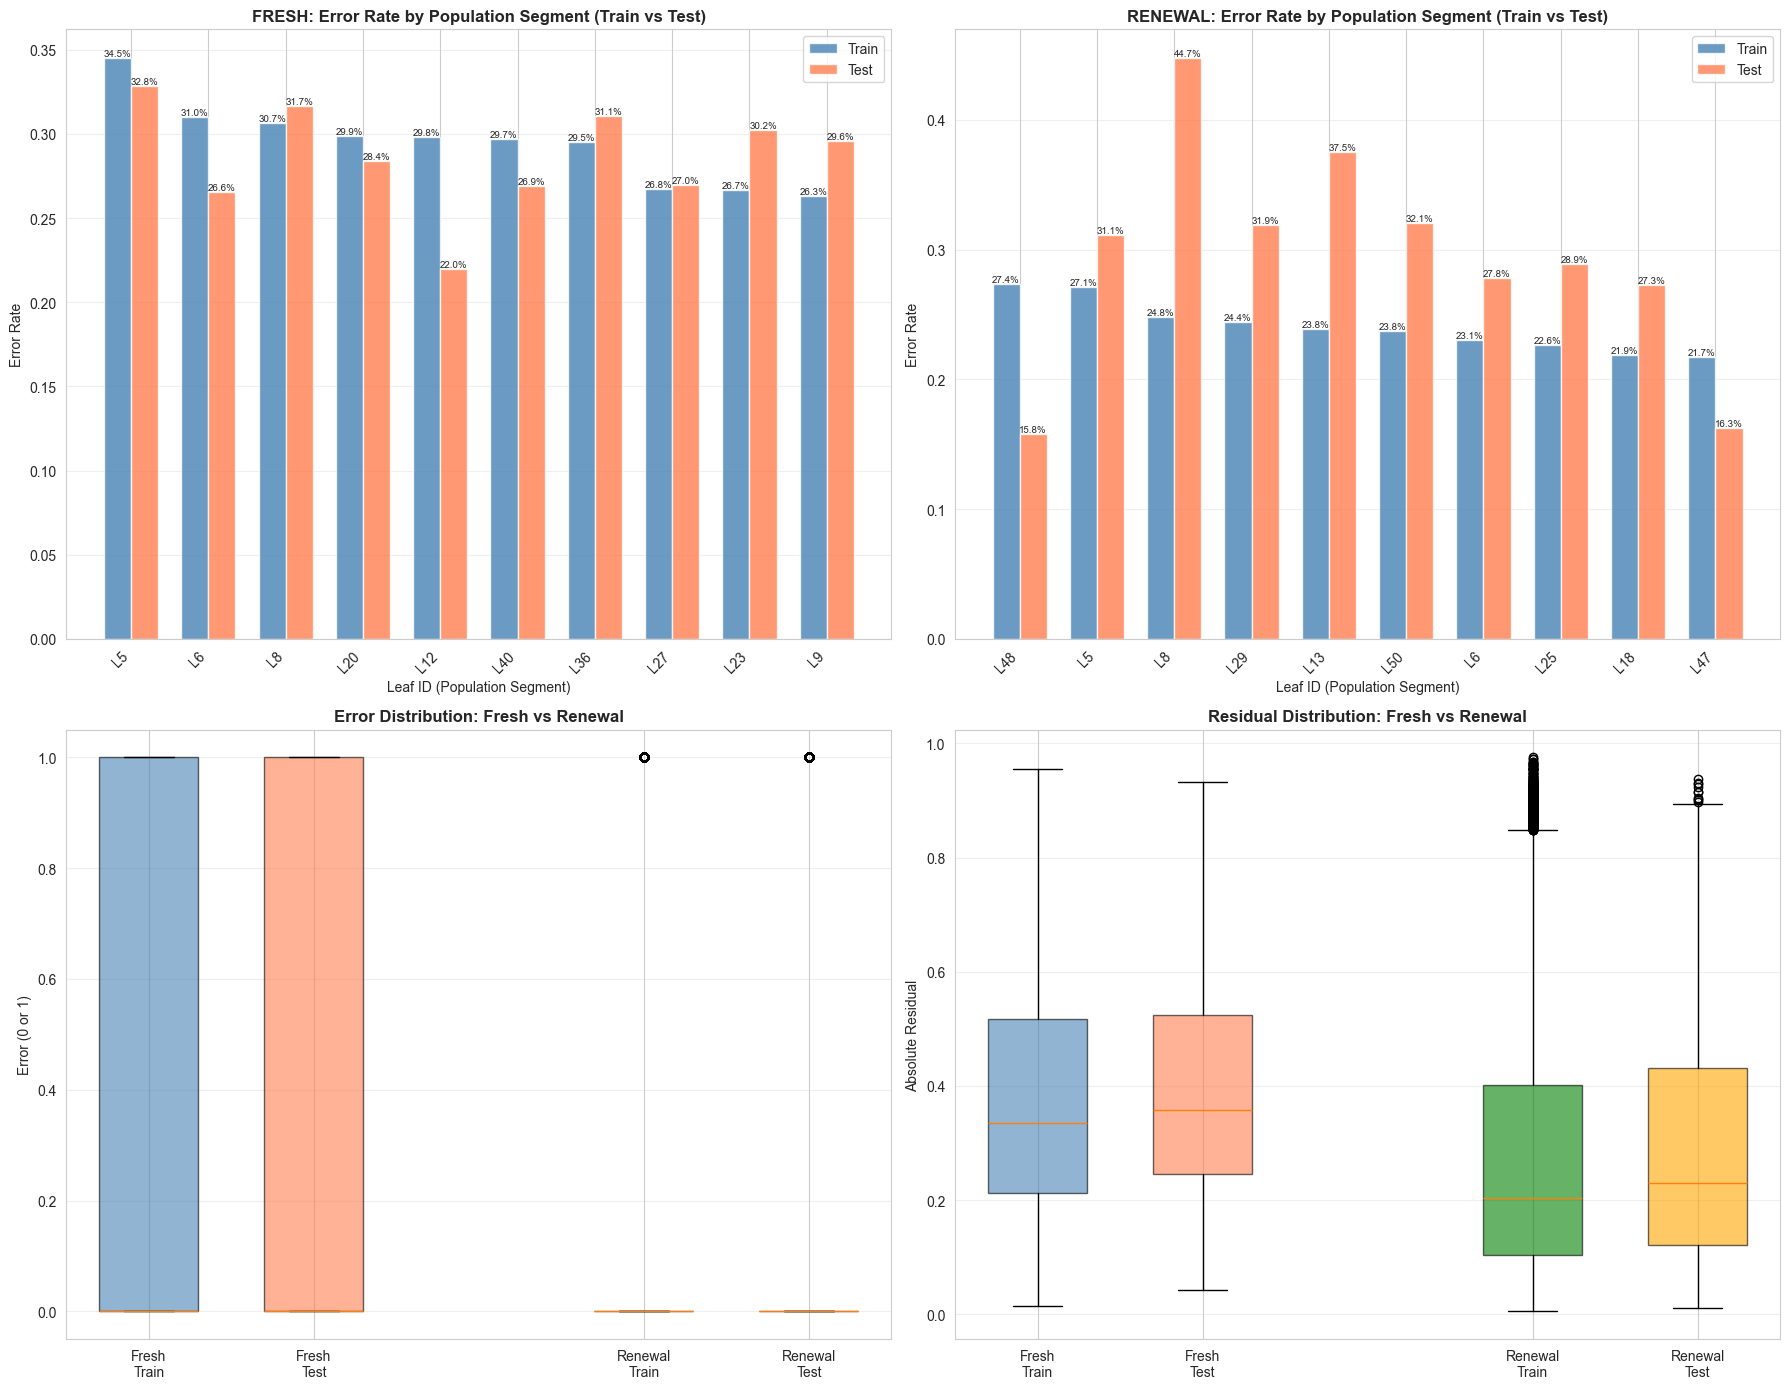

In [101]:
# Create visualization comparing error rates for Fresh vs Renewal
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Prepare Fresh leaf error summary
fresh_leaf_error_summary = []
for leaf_id in fresh_leaf_df['node_id'].unique():
    leaf_mask = fresh_combined_df['leaf_id'] == leaf_id
    leaf_samples = fresh_combined_df[leaf_mask]
    
    train_leaf = leaf_samples[leaf_samples['dataset'] == 'train']
    test_leaf = leaf_samples[leaf_samples['dataset'] == 'test']
    
    if len(train_leaf) > 0:
        fresh_leaf_error_summary.append({
            'leaf_id': leaf_id,
            'dataset': 'Train',
            'error_rate': train_leaf['error'].mean(),
            'n_samples': len(train_leaf)
        })
    
    if len(test_leaf) > 0:
        fresh_leaf_error_summary.append({
            'leaf_id': leaf_id,
            'dataset': 'Test',
            'error_rate': test_leaf['error'].mean(),
            'n_samples': len(test_leaf)
        })

fresh_leaf_error_df = pd.DataFrame(fresh_leaf_error_summary)

# Prepare Renewal leaf error summary
renewal_leaf_error_summary = []
for leaf_id in renewal_leaf_df['node_id'].unique():
    leaf_mask = renewal_combined_df['leaf_id'] == leaf_id
    leaf_samples = renewal_combined_df[leaf_mask]
    
    train_leaf = leaf_samples[leaf_samples['dataset'] == 'train']
    test_leaf = leaf_samples[leaf_samples['dataset'] == 'test']
    
    if len(train_leaf) > 0:
        renewal_leaf_error_summary.append({
            'leaf_id': leaf_id,
            'dataset': 'Train',
            'error_rate': train_leaf['error'].mean(),
            'n_samples': len(train_leaf)
        })
    
    if len(test_leaf) > 0:
        renewal_leaf_error_summary.append({
            'leaf_id': leaf_id,
            'dataset': 'Test',
            'error_rate': test_leaf['error'].mean(),
            'n_samples': len(test_leaf)
        })

renewal_leaf_error_df = pd.DataFrame(renewal_leaf_error_summary)

# Plot 1: Fresh Error rate by leaf
ax1 = axes[0, 0]
fresh_pivot = fresh_leaf_error_df.pivot(index='leaf_id', columns='dataset', values='error_rate')
fresh_pivot = fresh_pivot.sort_values('Train', ascending=False).head(10)

x1 = np.arange(len(fresh_pivot))
width = 0.35

bars1 = ax1.bar(x1 - width/2, fresh_pivot['Train'], width, label='Train', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x1 + width/2, fresh_pivot['Test'], width, label='Test', alpha=0.8, color='coral')

ax1.set_xlabel('Leaf ID (Population Segment)', fontsize=10)
ax1.set_ylabel('Error Rate', fontsize=10)
ax1.set_title('FRESH: Error Rate by Population Segment (Train vs Test)', fontsize=12, fontweight='bold')
ax1.set_xticks(x1)
ax1.set_xticklabels([f'L{int(lid)}' for lid in fresh_pivot.index], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%', ha='center', va='bottom', fontsize=7)

# Plot 2: Renewal Error rate by leaf
ax2 = axes[0, 1]
renewal_pivot = renewal_leaf_error_df.pivot(index='leaf_id', columns='dataset', values='error_rate')
renewal_pivot = renewal_pivot.sort_values('Train', ascending=False).head(10)

x2 = np.arange(len(renewal_pivot))

bars3 = ax2.bar(x2 - width/2, renewal_pivot['Train'], width, label='Train', alpha=0.8, color='steelblue')
bars4 = ax2.bar(x2 + width/2, renewal_pivot['Test'], width, label='Test', alpha=0.8, color='coral')

ax2.set_xlabel('Leaf ID (Population Segment)', fontsize=10)
ax2.set_ylabel('Error Rate', fontsize=10)
ax2.set_title('RENEWAL: Error Rate by Population Segment (Train vs Test)', fontsize=12, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels([f'L{int(lid)}' for lid in renewal_pivot.index], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%', ha='center', va='bottom', fontsize=7)

# Plot 3: Overall distribution comparison
ax3 = axes[1, 0]
error_data = [
    fresh_train_errors,
    fresh_test_errors,
    renewal_train_errors,
    renewal_test_errors
]
labels = ['Fresh\nTrain', 'Fresh\nTest', 'Renewal\nTrain', 'Renewal\nTest']
colors = ['steelblue', 'coral', 'green', 'orange']

positions = [1, 2, 4, 5]
bp = ax3.boxplot(error_data, positions=positions, labels=labels, patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax3.set_ylabel('Error (0 or 1)', fontsize=10)
ax3.set_title('Error Distribution: Fresh vs Renewal', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Residual distribution comparison
ax4 = axes[1, 1]
residual_data = [
    fresh_train_residuals,
    fresh_test_residuals,
    renewal_train_residuals,
    renewal_test_residuals
]

bp2 = ax4.boxplot(residual_data, positions=positions, labels=labels, patch_artist=True, widths=0.6)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax4.set_ylabel('Absolute Residual', fontsize=10)
ax4.set_title('Residual Distribution: Fresh vs Renewal', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Feature Importance for Error Prediction - Fresh vs Renewal


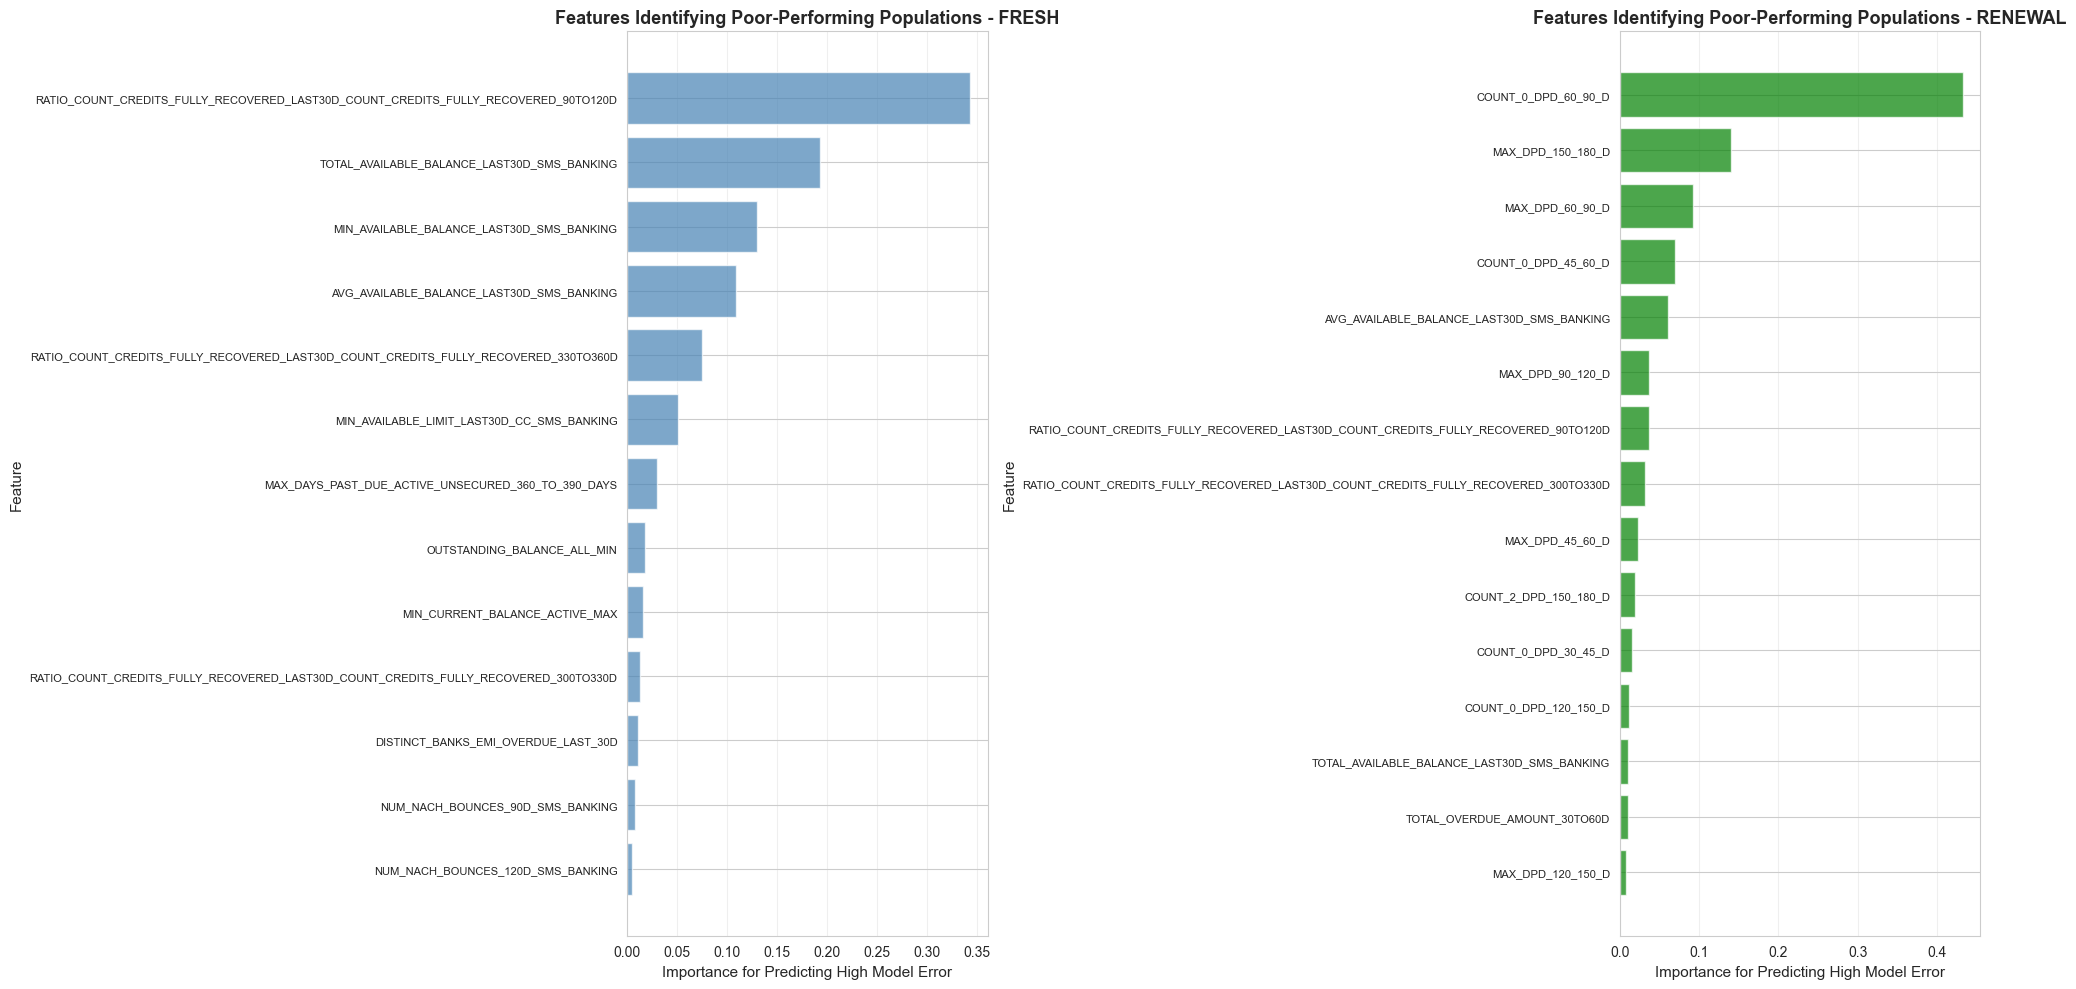

FEATURES THAT BEST PREDICT WHERE MODEL PERFORMS POORLY

FRESH CUSTOMERS

Rank   Feature                                                                                              Importance     
------ ---------------------------------------------------------------------------------------------------- ---------------
1      RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_90TO120D                   0.343308       
2      TOTAL_AVAILABLE_BALANCE_LAST30D_SMS_BANKING                                                          0.192929       
3      MIN_AVAILABLE_BALANCE_LAST30D_SMS_BANKING                                                            0.129666       
4      AVG_AVAILABLE_BALANCE_LAST30D_SMS_BANKING                                                            0.109010       
5      RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_330TO360D                  0.074276       
6      MIN_AVAILABLE_LIMIT_LAST30D_CC_SMS_BANKING          

In [102]:
# Extract feature importance from error prediction trees
fresh_error_tree_importance = pd.DataFrame({
    'Feature': top_30_features,
    'Importance': dt_fresh_error.feature_importances_
})
fresh_error_tree_importance = fresh_error_tree_importance.sort_values('Importance', ascending=False)
fresh_error_tree_importance = fresh_error_tree_importance[fresh_error_tree_importance['Importance'] > 0]

renewal_error_tree_importance = pd.DataFrame({
    'Feature': top_30_features,
    'Importance': dt_renewal_error.feature_importances_
})
renewal_error_tree_importance = renewal_error_tree_importance.sort_values('Importance', ascending=False)
renewal_error_tree_importance = renewal_error_tree_importance[renewal_error_tree_importance['Importance'] > 0]

# Visualize side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Fresh features
ax1 = axes[0]
top_fresh_features = fresh_error_tree_importance.head(15)
bars1 = ax1.barh(range(len(top_fresh_features)), top_fresh_features['Importance'].values, 
                 color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(top_fresh_features)))
ax1.set_yticklabels(top_fresh_features['Feature'].values, fontsize=8)
ax1.set_xlabel('Importance for Predicting High Model Error', fontsize=11)
ax1.set_ylabel('Feature', fontsize=11)
ax1.set_title('Features Identifying Poor-Performing Populations - FRESH', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Renewal features
ax2 = axes[1]
top_renewal_features = renewal_error_tree_importance.head(15)
bars2 = ax2.barh(range(len(top_renewal_features)), top_renewal_features['Importance'].values, 
                 color='green', alpha=0.7)
ax2.set_yticks(range(len(top_renewal_features)))
ax2.set_yticklabels(top_renewal_features['Feature'].values, fontsize=8)
ax2.set_xlabel('Importance for Predicting High Model Error', fontsize=11)
ax2.set_ylabel('Feature', fontsize=11)
ax2.set_title('Features Identifying Poor-Performing Populations - RENEWAL', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 120)
print("FEATURES THAT BEST PREDICT WHERE MODEL PERFORMS POORLY")
print("=" * 120)

print("\n" + "=" * 120)
print("FRESH CUSTOMERS")
print("=" * 120)
print(f"\n{'Rank':<6} {'Feature':<100} {'Importance':<15}")
print(f"{'-'*6} {'-'*100} {'-'*15}")
for idx, row in fresh_error_tree_importance.head(10).iterrows():
    rank = fresh_error_tree_importance.index.get_loc(idx) + 1
    print(f"{rank:<6} {row['Feature']:<100} {row['Importance']:<15.6f}")

print("\n" + "=" * 120)
print("RENEWAL CUSTOMERS")
print("=" * 120)
print(f"\n{'Rank':<6} {'Feature':<100} {'Importance':<15}")
print(f"{'-'*6} {'-'*100} {'-'*15}")
for idx, row in renewal_error_tree_importance.head(10).iterrows():
    rank = renewal_error_tree_importance.index.get_loc(idx) + 1
    print(f"{rank:<6} {row['Feature']:<100} {row['Importance']:<15.6f}")


### Key Insights Summary - Fresh vs Renewal


In [103]:
print("=" * 120)
print("KEY INSIGHTS: MODEL PERFORMANCE ON FRESH VS RENEWAL CUSTOMERS")
print("=" * 120)

print("\n📊 OVERALL PERFORMANCE COMPARISON:")
print("\n  FRESH CUSTOMERS:")
print(f"    - Train Error Rate: {fresh_train_errors.mean()*100:.2f}%")
print(f"    - Test Error Rate: {fresh_test_errors.mean()*100:.2f}%")
print(f"    - Train AUC-ROC: {fresh_train_metrics['AUC-ROC']:.4f}")
print(f"    - Test AUC-ROC: {fresh_test_metrics['AUC-ROC']:.4f}")

print("\n  RENEWAL CUSTOMERS:")
print(f"    - Train Error Rate: {renewal_train_errors.mean()*100:.2f}%")
print(f"    - Test Error Rate: {renewal_test_errors.mean()*100:.2f}%")
print(f"    - Train AUC-ROC: {renewal_train_metrics['AUC-ROC']:.4f}")
print(f"    - Test AUC-ROC: {renewal_test_metrics['AUC-ROC']:.4f}")

# Determine which segment performs better
if fresh_test_metrics['AUC-ROC'] > renewal_test_metrics['AUC-ROC']:
    better_segment = "FRESH"
    worse_segment = "RENEWAL"
    auc_diff = fresh_test_metrics['AUC-ROC'] - renewal_test_metrics['AUC-ROC']
else:
    better_segment = "RENEWAL"
    worse_segment = "FRESH"
    auc_diff = renewal_test_metrics['AUC-ROC'] - fresh_test_metrics['AUC-ROC']

print(f"\n  ⚡ Model performs BETTER on {better_segment} customers (AUC difference: {auc_diff:.4f})")

print("\n🎯 POOR-PERFORMING POPULATIONS:")

# Analyze Fresh poor populations
fresh_poor_leaves = fresh_leaf_df.head(3)
print(f"\n  FRESH CUSTOMERS - Top 3 worst populations:")
for idx, row in fresh_poor_leaves.iterrows():
    print(f"    • Leaf {row['node_id']}: {row['high_error_rate']*100:.1f}% high error rate ({row['n_samples']:,} samples)")

# Analyze Renewal poor populations
renewal_poor_leaves = renewal_leaf_df.head(3)
print(f"\n  RENEWAL CUSTOMERS - Top 3 worst populations:")
for idx, row in renewal_poor_leaves.iterrows():
    print(f"    • Leaf {row['node_id']}: {row['high_error_rate']*100:.1f}% high error rate ({row['n_samples']:,} samples)")

print("\n🔍 KEY DIFFERENCES BETWEEN FRESH AND RENEWAL:")

print("\n  FEATURES DRIVING POOR PERFORMANCE:")
print(f"\n    Fresh Top 3:")
for idx, row in fresh_error_tree_importance.head(3).iterrows():
    print(f"      {fresh_error_tree_importance.index.get_loc(idx) + 1}. {row['Feature']}")

print(f"\n    Renewal Top 3:")
for idx, row in renewal_error_tree_importance.head(3).iterrows():
    print(f"      {renewal_error_tree_importance.index.get_loc(idx) + 1}. {row['Feature']}")

# Compare calibration
fresh_calibration_gap = fresh_combined_df['predicted'].mean() - fresh_combined_df['actual'].mean()
renewal_calibration_gap = renewal_combined_df['predicted'].mean() - renewal_combined_df['actual'].mean()

print("\n  CALIBRATION ANALYSIS:")
print(f"    Fresh - Actual default rate: {fresh_combined_df['actual'].mean()*100:.2f}%")
print(f"    Fresh - Predicted default rate: {fresh_combined_df['predicted'].mean()*100:.2f}%")
print(f"    Fresh - Calibration gap: {fresh_calibration_gap*100:.2f} percentage points")

print(f"\n    Renewal - Actual default rate: {renewal_combined_df['actual'].mean()*100:.2f}%")
print(f"    Renewal - Predicted default rate: {renewal_combined_df['predicted'].mean()*100:.2f}%")
print(f"    Renewal - Calibration gap: {renewal_calibration_gap*100:.2f} percentage points")

if abs(fresh_calibration_gap) < abs(renewal_calibration_gap):
    print(f"\n    ⚠️ Model is BETTER CALIBRATED for Fresh customers")
else:
    print(f"\n    ⚠️ Model is BETTER CALIBRATED for Renewal customers")

# Prediction bias
if fresh_calibration_gap < 0:
    print(f"\n    📉 Model UNDER-PREDICTS risk for Fresh customers (missing {abs(fresh_calibration_gap)*100:.2f}% of defaults)")
else:
    print(f"\n    📈 Model OVER-PREDICTS risk for Fresh customers (too conservative by {fresh_calibration_gap*100:.2f}%)")

if renewal_calibration_gap < 0:
    print(f"    📉 Model UNDER-PREDICTS risk for Renewal customers (missing {abs(renewal_calibration_gap)*100:.2f}% of defaults)")
else:
    print(f"    📈 Model OVER-PREDICTS risk for Renewal customers (too conservative by {renewal_calibration_gap*100:.2f}%)")

print("\n💡 RECOMMENDATIONS:")
print("\n  FOR FRESH CUSTOMERS:")
print("    1. Focus on improving predictions in populations identified by top error-predicting features")
print("    2. Consider separate threshold calibration for Fresh segment")
print("    3. Investigate if Fresh customers have distinct behavioral patterns not captured by current features")

print("\n  FOR RENEWAL CUSTOMERS:")
print("    1. Leverage historical repayment data more effectively (if available)")
print("    2. Consider segment-specific feature engineering for Renewal customers")
print("    3. Evaluate if a separate model for Renewal customers would improve performance")

print("\n  OVERALL:")
if better_segment == "FRESH":
    print(f"    ⚠️ RENEWAL customers show weaker model performance - prioritize improvements here")
else:
    print(f"    ⚠️ FRESH customers show weaker model performance - prioritize improvements here")

print("    1. Consider building separate models or applying different thresholds for Fresh vs Renewal")
print("    2. Implement segment-specific monitoring and recalibration strategies")
print("    3. Review data quality and feature availability across both segments")

print("\n" + "=" * 120)


KEY INSIGHTS: MODEL PERFORMANCE ON FRESH VS RENEWAL CUSTOMERS

📊 OVERALL PERFORMANCE COMPARISON:

  FRESH CUSTOMERS:
    - Train Error Rate: 26.83%
    - Test Error Rate: 27.29%
    - Train AUC-ROC: 0.7654
    - Test AUC-ROC: 0.6497

  RENEWAL CUSTOMERS:
    - Train Error Rate: 18.02%
    - Test Error Rate: 19.17%
    - Train AUC-ROC: 0.8748
    - Test AUC-ROC: 0.8164

  ⚡ Model performs BETTER on RENEWAL customers (AUC difference: 0.1667)

🎯 POOR-PERFORMING POPULATIONS:

  FRESH CUSTOMERS - Top 3 worst populations:
    • Leaf 5: 30.5% high error rate (19,439 samples)
    • Leaf 8: 29.0% high error rate (8,961 samples)
    • Leaf 12: 28.0% high error rate (1,095 samples)

  RENEWAL CUSTOMERS - Top 3 worst populations:
    • Leaf 5: 44.8% high error rate (3,313 samples)
    • Leaf 50: 40.0% high error rate (693 samples)
    • Leaf 29: 39.6% high error rate (543 samples)

🔍 KEY DIFFERENCES BETWEEN FRESH AND RENEWAL:

  FEATURES DRIVING POOR PERFORMANCE:

    Fresh Top 3:
      1. RATIO_C